In [1]:
import tuw_nlp
tuw_nlp.download_alto()
tuw_nlp.download_definitions()

from xpotato.dataset.dataset import Dataset
from xpotato.models.trainer import GraphTrainer
from xpotato.models.utils import to_dot
from xpotato.graph_extractor.extract import FeatureEvaluator
from xpotato.dataset.utils import save_dataframe
from xpotato.dataset.utils import ud_to_graph
from xpotato.dataset.utils import default_pn_to_graph
from xpotato.dataset.utils import amr_pn_to_graph

from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import stanza
import os
from graphviz import Source
import pickle
import json

stanza.download("en")
stanza.download("de")
stanza.download(lang="en",package=None,processors={"pos":"craft"})


2023-01-13 16:24:49,736 : common (424) - INFO - Downloading default packages for language: en (English)...
2023-01-13 16:24:50,974 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\default.zip.
2023-01-13 16:24:54,499 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-13 16:24:54,539 : common (424) - INFO - Downloading default packages for language: de (German)...
2023-01-13 16:24:56,218 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\de\default.zip.
2023-01-13 16:25:00,782 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-13 16:25:00,838 : common (446) - INFO - Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| pos       | craft   |
| pretrain  | craft   |

2023-01-13 16:25:00,894 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\pos\craft.pt.
2023-01-13 1

In [2]:
df = pd.read_csv(Path('../data/milestone3/preprocessed.csv'), sep=';')
df.head()


,term1,term2,sentence,is_cause,is_treat,source,prp_sent,sdp,sdp_joined
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use term1 as...","['term1', 'use', 'as', 'medicine', 'for', 'tre...",term1 use as medicine for treatment of term2
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,term1 consumption has been associated with sev...,"['term1', 'consumption', 'associate', 'with', ...",term1 consumption associate with outcome as term2
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,term1 has notoriously been blamed for causing ...,"['term1', 'blame', 'for', 'term2']",term1 blame for term2
3,broiler chicken,footpad dermatitis,in broiler chicken flocks when animal-based me...,0,0,FoodDisease,in term1 flocks when animal-based measures rel...,"['term1', 'flock', 'in', 'identify', 'burn', '...","term1 flock in identify burn , term2"
4,sfp,diabetes,"in short, this study demonstrated that sfp cou...",0,1,FoodDisease,"in short, this study demonstrated that term1 c...","['term1', 'develop', 'as', 'food', 'or', 'prev...",term1 develop as food or prevention of term2


In [3]:
def make_sentences(column="is_cause", df=df):
    sentences = []
    for i, row in df.iterrows():
        if row[column]:
            relation = 'cause'
        else:
            relation = 'not'
        sentence = row['sentence'].encode('ascii', errors='ignore').decode('utf-8')
        sentences.append((sentence, relation))
    return sentences

In [4]:
sentences_cause = make_sentences("is_cause", df)
sentences_treat = make_sentences("is_treat", df)

In [5]:
sentences_cause[1:10]

[('ultra-processed food consumption has been associated with several health outcomes such as obesity, hypertension, cardiovascular disease and cancer.',
  'cause'),
 ('salt has notoriously been blamed for causing an increase in the urinary excretion of calcium, and thus is a considered a risk factor for osteoporosis.',
  'cause'),
 ('in broiler chicken flocks when animal-based measures related to footpad dermatitis, hock burns, body lesions and arthritis are identified under commercial conditions (high density).',
  'not'),
 ('in short, this study demonstrated that sfp could be developed as functional foods or pharmaceutical supplements for the prevention or mitigation of diabetes and its complications.',
  'not'),
 ('we also showed that moderate consumption of wine was associated with a lower risk of developing ad.',
  'not'),
 ('recent evidence revealed the potential of ginger for reducing diabetes-induced oxidative stress markers.',
  'not'),
 ('total phenolic extracts of citrus aur

In [6]:
dataset_cause = Dataset(sentences_cause, label_vocab={"not":0, "cause": 1}, lang="en")
dataset_treat = Dataset(sentences_treat, label_vocab={"not":0, "treat": 1}, lang="en")

In [7]:
# make graphs, very slow
# dataset_cause.set_graphs(dataset_cause.parse_graphs(graph_format="fourlang"))
# dataset_treat.set_graphs(dataset_treat.parse_graphs(graph_format="fourlang"))

In [8]:
# make dataframes
# df_cause = dataset_cause.to_dataframe()
# df_treat = dataset_treat.to_dataframe()

In [9]:
# save dataframes
# save_dataframe(df_cause, 'df_cause_graphs.tsv')
# save_dataframe(df_treat, 'df_treat_graphs.tsv')

In [10]:
df_cause = pd.read_csv(Path('df_graphs.tsv'), sep='\t')
df_cause['graph'].head()

0    (u_0 / use  :2 (u_1 / fruit  :0 (u_2 / bombaca...
1    (u_18 / associate  :2 (u_19 / consumption  :0 ...
2    (u_27 / COORD  :0 (u_33 / factor  :0 (u_34 / r...
3    (u_46 / identify  :2 (u_47 / measure  :0 (u_48...
4    (u_67 / demonstrate  :0 (u_68 / develop  :2 (u...
Name: graph, dtype: object

In [11]:
df_cause['graph'] = df_cause['graph'].apply(lambda x: amr_pn_to_graph(x)[0])

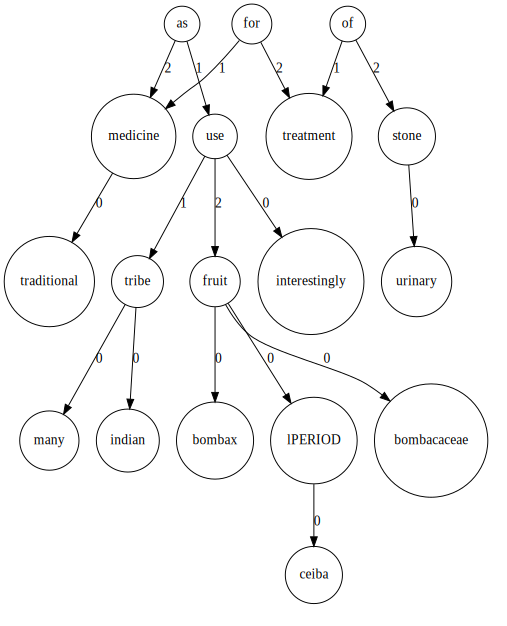

In [12]:
Source(to_dot(df_cause.iloc[0].graph))

In [36]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / for)"], [], "cause"]]

evaluator = FeatureEvaluator()

#match single feature
df_tmp = evaluator.match_features(df_cause, rule_to_match)
rows = []
for i,row in df_tmp.iterrows():
    if row['Predicted label'] == 'cause':
        row['graph'] = df_cause.iloc[i].graph
        rows.append(row)
df_tmp = pd.DataFrame(rows, columns=['Sentence', 'Predicted label', 'Matched rule', 'graph']).reset_index(drop=True)
df_tmp

7978it [00:01, 5572.80it/s]


,Sentence,Predicted label,Matched rule,graph
0,"interestingly, many indian tribes use bombax c...",cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,salt has notoriously been blamed for causing a...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"in short, this study demonstrated that sfp cou...",cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,mnds remain a major public health concern part...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,glycine max is commonly used in algeria for tr...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...
1572,PARACETAMOL (acetaminophen) was the most commo...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8)"
1573,We collected resource use data prospectively f...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1574,Since the introduction of TRICYCLIC ANTIDEPRES...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1575,ALL TRANS RETINOIC ACID (ATRA) is the drug of ...,cause,"[[(u_1 / for)], [], cause]","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)"


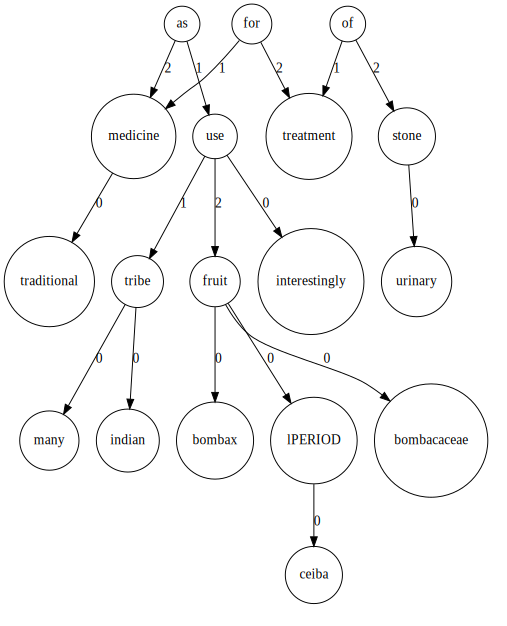

In [44]:
Source(to_dot(df_tmp.iloc[0].graph))

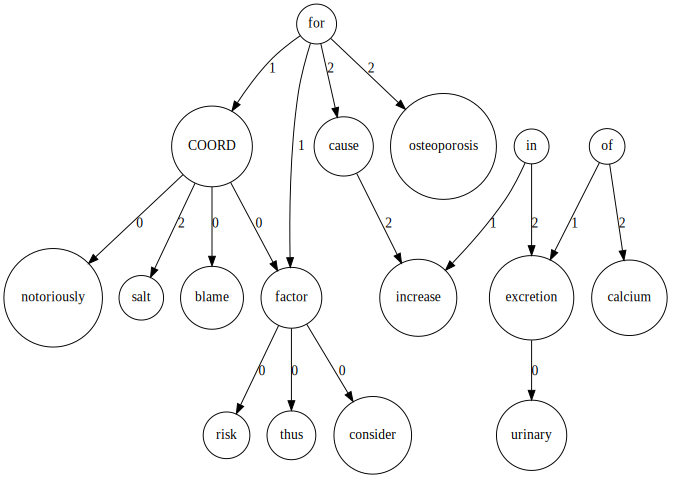

In [45]:
Source(to_dot(df_tmp.iloc[1].graph))

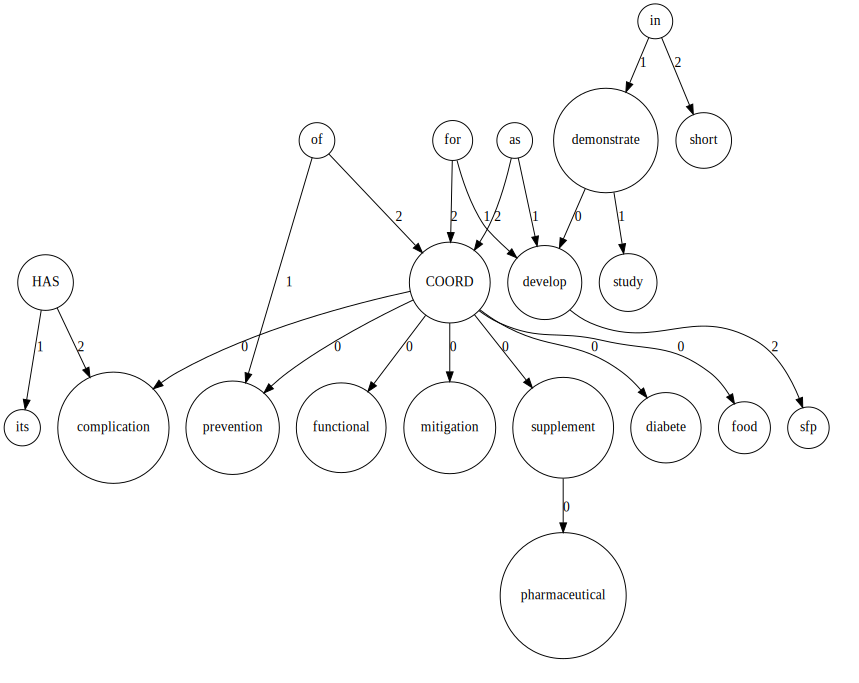

In [46]:
Source(to_dot(df_tmp.iloc[2].graph))

Learning rules

In [14]:
trainer = GraphTrainer(df_cause)
#extract features
features = trainer.prepare_and_train()

train, val = train_test_split(df_cause, test_size=0.2, random_state=1234)

#save train and validation, this is important for the frontend to work
save_dataframe(train, 'train.tsv')
save_dataframe(val, 'val.tsv')

#also save the ranked features
with open("features.json", "w+") as f:
    json.dump(features, f)


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


7978it [01:15, 105.71it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...


c:\Users\Ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Getting features...


In [15]:
with open("graphs.pickle", "wb") as f:
    pickle.dump(val.graph, f)